# Setting Up 

In [26]:
from sqlalchemy import create_engine, Table, inspect, MetaData
import pandas as pd
import seaborn as sns

# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [3]:
# Database connection parameters
server = 'localhost'  # or the IP of your SQL Server if it's remote
database = 'AdventureWorks2022'
username = 'SA'  # or your SQL Server username
password = 'Pwd_12345'  # Replace with your actual password

# Connection string for SQLAlchemy
#connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'
#connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC%20Driver%2017%20for%20SQL%20Server"

connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=/opt/homebrew/lib/libmsodbcsql.17.dylib'

# Create engine
engine = create_engine(connection_string)

connection = engine.connect()
inspector = inspect(engine)
schemas = inspector.get_schema_names()
print(schemas)

['db_accessadmin', 'db_backupoperator', 'db_datareader', 'db_datawriter', 'db_ddladmin', 'db_denydatareader', 'db_denydatawriter', 'db_owner', 'db_securityadmin', 'dbo', 'guest', 'HumanResources', 'INFORMATION_SCHEMA', 'Person', 'Production', 'Purchasing', 'Sales', 'sys']


In [4]:
print(inspector.get_table_names(schema='Sales'))

['CountryRegionCurrency', 'CreditCard', 'Currency', 'CurrencyRate', 'Customer', 'PersonCreditCard', 'SalesOrderDetail', 'SalesOrderHeader', 'SalesOrderHeaderSalesReason', 'SalesPerson', 'SalesPersonQuotaHistory', 'SalesReason', 'SalesTaxRate', 'SalesTerritory', 'SalesTerritoryHistory', 'ShoppingCartItem', 'SpecialOffer', 'SpecialOfferProduct', 'Store']


In [5]:
for col in inspector.get_columns(table_name='Customer', schema='Sales'):
#     print(col)
    print(col['name'])

CustomerID
PersonID
StoreID
TerritoryID
AccountNumber
rowguid
ModifiedDate


# Creating DB overview DF

In [6]:

metadata = MetaData()


# Function to get an overview of all tables for each schema and create a DataFrame
def get_schema_overview_dataframe(engine):
    data = []

    # Get all schemas in the database
    schemas = inspector.get_schema_names()

    for schema in schemas:
        # Get all tables in each schema
        for table_name in inspector.get_table_names(schema=schema):
            # Reflect table to get detailed info
            table = Table(table_name, metadata, autoload_with=engine, schema=schema)
            primary_keys = set(table.primary_key.columns.keys())
            foreign_keys = set([fk.parent.name for fk in table.foreign_keys])

            # Get columns for each table
            for column in inspector.get_columns(table_name, schema=schema):
                key_type = None
                if column['name'] in primary_keys:
                    key_type = 'Primary Key'
                elif column['name'] in foreign_keys:
                    key_type = 'Foreign Key'
                
                col_info = {
                    'Schema': schema,
                    'Table': table_name,
                    'Column': column['name'],
                    'Type': str(column['type']),
                    'Key': key_type
                }
                data.append(col_info)

    # Create DataFrame
    df = pd.DataFrame(data)
    return df

# Execute the function and create the DataFrame
schema_overview_df = get_schema_overview_dataframe(engine)


/var/folders/l6/_mq5j9z968v8v8r5l_th36vr0000gn/T/ipykernel_60631/951905457.py:15: SAWarning: Did not recognize type 'hierarchyid' of column 'OrganizationNode'
  table = Table(table_name, metadata, autoload_with=engine, schema=schema)
/var/folders/l6/_mq5j9z968v8v8r5l_th36vr0000gn/T/ipykernel_60631/951905457.py:20: SAWarning: Did not recognize type 'hierarchyid' of column 'OrganizationNode'
  for column in inspector.get_columns(table_name, schema=schema):
/var/folders/l6/_mq5j9z968v8v8r5l_th36vr0000gn/T/ipykernel_60631/951905457.py:15: SAWarning: Did not recognize type 'geography' of column 'SpatialLocation'
  table = Table(table_name, metadata, autoload_with=engine, schema=schema)
/var/folders/l6/_mq5j9z968v8v8r5l_th36vr0000gn/T/ipykernel_60631/951905457.py:20: SAWarning: Did not recognize type 'geography' of column 'SpatialLocation'
  for column in inspector.get_columns(table_name, schema=schema):
/var/folders/l6/_mq5j9z968v8v8r5l_th36vr0000gn/T/ipykernel_60631/951905457.py:15: SAWarn

In [7]:
schema_overview_df.head()

,Schema,Table,Column,Type,Key
0,dbo,AWBuildVersion,SystemInformationID,TINYINT,Primary Key
1,dbo,AWBuildVersion,Database Version,"NVARCHAR(25) COLLATE ""SQL_Latin1_General_CP1_C...",None
2,dbo,AWBuildVersion,VersionDate,DATETIME,None
3,dbo,AWBuildVersion,ModifiedDate,DATETIME,None
4,dbo,DatabaseLog,DatabaseLogID,INTEGER,Primary Key


In [8]:
# Understanding keys for each schama

keys_overview = schema_overview_df.groupby(['Schema','Table','Key'])['Column'].max().to_frame().reset_index()
keys_overview.head(20)

,Schema,Table,Key,Column
0,HumanResources,Department,Primary Key,DepartmentID
1,HumanResources,Employee,Primary Key,BusinessEntityID
2,HumanResources,EmployeeDepartmentHistory,Primary Key,StartDate
3,HumanResources,EmployeePayHistory,Primary Key,RateChangeDate
4,HumanResources,JobCandidate,Foreign Key,BusinessEntityID
5,HumanResources,JobCandidate,Primary Key,JobCandidateID
6,HumanResources,Shift,Primary Key,ShiftID
7,Person,Address,Foreign Key,StateProvinceID
8,Person,Address,Primary Key,AddressID
9,Person,AddressType,Primary Key,AddressTypeID


# DB analysis

In [9]:
# schemas
list_of_schemas = schema_overview_df['Schema'].unique()

In [19]:
list_of_schemas

array(['dbo', 'HumanResources', 'Person', 'Production', 'Purchasing',
       'Sales'], dtype=object)

In [10]:
for schema in list_of_schemas:
    print(schema)
    print(schema_overview_df[schema_overview_df['Schema'] == schema][['Schema','Table']].drop_duplicates())
    print('___________________________')

dbo
   Schema           Table
0     dbo  AWBuildVersion
4     dbo     DatabaseLog
12    dbo        ErrorLog
___________________________
HumanResources
            Schema                      Table
21  HumanResources                 Department
25  HumanResources                   Employee
41  HumanResources  EmployeeDepartmentHistory
47  HumanResources         EmployeePayHistory
52  HumanResources               JobCandidate
56  HumanResources                      Shift
___________________________
Person
     Schema                  Table
61   Person                Address
70   Person            AddressType
74   Person         BusinessEntity
77   Person  BusinessEntityAddress
82   Person  BusinessEntityContact
87   Person            ContactType
90   Person          CountryRegion
93   Person           EmailAddress
98   Person               Password
103  Person                 Person
116  Person            PersonPhone
120  Person        PhoneNumberType
123  Person          StateProvince
__

In [17]:
schema_overview_df[schema_overview_df['Schema'] == 'HumanResources'][['Table', 'Column','Key', 'Type']].drop_duplicates().head()

,Table,Column,Key,Type
21,Department,DepartmentID,Primary Key,SMALLINT
22,Department,Name,None,"NVARCHAR(50) COLLATE ""SQL_Latin1_General_CP1_C..."
23,Department,GroupName,None,"NVARCHAR(50) COLLATE ""SQL_Latin1_General_CP1_C..."
24,Department,ModifiedDate,None,DATETIME
25,Employee,BusinessEntityID,Primary Key,INTEGER


In [18]:

for col in inspector.get_columns(table_name='Employee', schema='HumanResources'):
    #columns_to_select.append(col['name'])
    print(col['name']+',')



# # Stripping single quotes from each item in the list
# columns_to_select = [item.strip("'") for item in columns_to_select]

# columns_to_select

BusinessEntityID,
NationalIDNumber,
LoginID,
OrganizationNode,
OrganizationLevel,
JobTitle,
BirthDate,
MaritalStatus,
Gender,
HireDate,
SalariedFlag,
VacationHours,
SickLeaveHours,
CurrentFlag,
rowguid,
ModifiedDate,


# 1. Employees Table, Discriptive statistics, Gender Equality 

In [21]:
employee = pd.read_sql(sql = """SELECT BusinessEntityID,
                        NationalIDNumber,
                        LoginID,
                        OrganizationLevel,
                        JobTitle,
                        BirthDate,
                        MaritalStatus,
                        Gender,
                        HireDate,
                        SalariedFlag,
                        VacationHours,
                        SickLeaveHours,
                        CurrentFlag,
                        rowguid,
                        ModifiedDate from HumanResources.Employee""", con=connection)

In [16]:
### Descriptive statistics

In [34]:
employee.describe()[['BusinessEntityID', 'OrganizationLevel', 'VacationHours',
       'SickLeaveHours']]

,BusinessEntityID,OrganizationLevel,VacationHours,SickLeaveHours
count,290.000000,289.000000,290.000000,290.000000
mean,145.500000,3.522491,50.613793,45.306897
min,1.000000,1.000000,0.000000,20.000000
25%,73.250000,3.000000,26.250000,33.000000
50%,145.500000,4.000000,51.000000,46.000000
75%,217.750000,4.000000,75.000000,58.000000
max,290.000000,4.000000,99.000000,80.000000
std,83.860002,0.750240,28.786215,14.540444


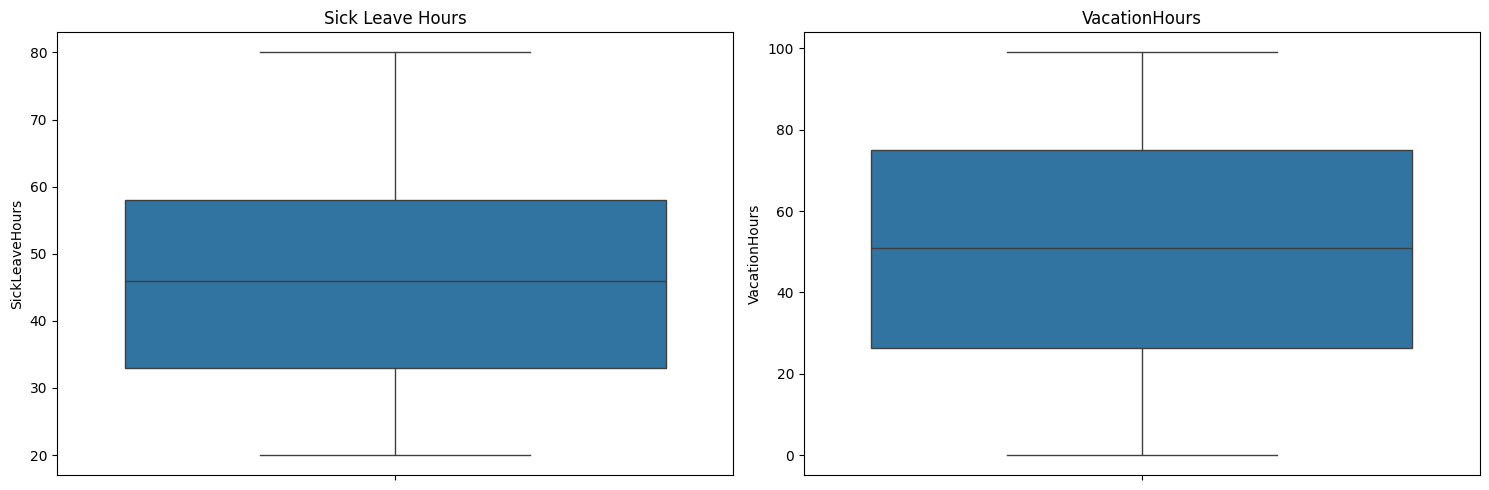

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Sample data
np.random.seed(0)
data = employee

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Second plot: Barplot
sns.boxplot(y='SickLeaveHours',  data=data, ax=axes[0])
axes[0].set_title('Sick Leave Hours')

# Third plot: Lineplot
sns.boxplot(y='VacationHours',  data=data, ax=axes[1])
axes[1].set_title('VacationHours')

# Show the plot
plt.tight_layout()
plt.show()


### Gender equality

In [42]:
sql = '''SELECT gender, COUNT(*) AS count
FROM HumanResources.Employee
WHERE CurrentFlag = 'True'
GROUP BY gender'''

gender = pd.read_sql(sql , con=connection)

In [43]:
gender

,gender,count
0,F,84
1,M,206


/var/folders/l6/_mq5j9z968v8v8r5l_th36vr0000gn/T/ipykernel_60631/2324691775.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='gender', y='count', data=gender, palette=["#6495ED", "#FF6F61"])


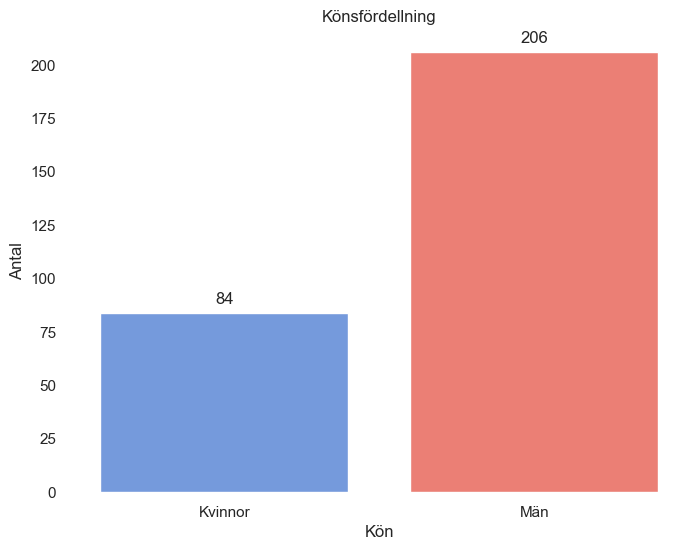

In [53]:
# Setting the style to 'white' which has no frames
sns.set(style="white")
# Plotting
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='gender', y='count', data=gender, palette=["#6495ED", "#FF6F61"])
plt.title('Könsfördellning')
plt.xlabel('Kön')
plt.ylabel('Antal')
plt.xticks([0, 1], ['Kvinnor', 'Män'])  # Labeling for clarity

# Removing the frame
for spine in bar_plot.spines.values():
    spine.set_visible(False)

# Adding the numbers above the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')

plt.show()



### 2. Average age Man and Woman

In [54]:
# 1. avarage age 

sql = ''' 
    SELECT 
    gender, 
    AVG(DATEDIFF(YEAR, BirthDate, GETDATE())) AS average_age,
    MAX(DATEDIFF(YEAR, BirthDate, GETDATE())) AS max_age,
    MIN(DATEDIFF(YEAR, BirthDate, GETDATE())) AS min_age
FROM 
    HumanResources.Employee
WHERE 
    gender IN ('F', 'M') AND CurrentFlag = 'True'
GROUP BY 
    gender;
'''

pd.read_sql(sql , con=connection)

,gender,average_age,max_age,min_age
0,F,46,72,33
1,M,45,73,33


# Hypothesis testing

Vem s'ljer mest? Man eller Kvinnor? 

# Hypothesis testing

Vem säljer mest? Man eller Kvinnor?

```
HumanResources
Schema                      Table
21  HumanResources                 Department
25  HumanResources                   Employee
41  HumanResources  EmployeeDepartmentHistory
47  HumanResources         EmployeePayHistory
52  HumanResources               JobCandidate
56  HumanResources                      Shift

Sales
Schema                        Table
349  Sales        CountryRegionCurrency
352  Sales                   CreditCard
358  Sales                     Currency
361  Sales                 CurrencyRate
368  Sales                     Customer
375  Sales             PersonCreditCard
378  Sales             SalesOrderDetail
389  Sales             SalesOrderHeader
415  Sales  SalesOrderHeaderSalesReason
418  Sales                  SalesPerson
427  Sales      SalesPersonQuotaHistory
432  Sales                  SalesReason
436  Sales                 SalesTaxRate
443  Sales               SalesTerritory
453  Sales        SalesTerritoryHistory
459  Sales             ShoppingCartItem
465  Sales                 SpecialOffer
476  Sales          SpecialOfferProduct
480  Sales                        Store
 ```



In [55]:
# Sales person tables

sales_person = pd.read_sql(sql = """SELECT * FROM Sales.SalesPerson""", con=connection)
sales_person.columns

Index(['BusinessEntityID', 'TerritoryID', 'SalesQuota', 'Bonus',
       'CommissionPct', 'SalesYTD', 'SalesLastYear', 'rowguid',
       'ModifiedDate'],
      dtype='object')

In [56]:
employee.columns

Index(['BusinessEntityID', 'NationalIDNumber', 'LoginID', 'OrganizationLevel',
       'JobTitle', 'BirthDate', 'MaritalStatus', 'Gender', 'HireDate',
       'SalariedFlag', 'VacationHours', 'SickLeaveHours', 'CurrentFlag',
       'rowguid', 'ModifiedDate'],
      dtype='object')

In [57]:
# Join Sales Person and Employee and compare total sale per Gender Statistically 
sql = """ 
SELECT 
    e.Gender,
    s.SalesQuota,
    s.SalesLastYear
FROM HumanResources.Employee as e
INNER JOIN Sales.SalesPerson as s
    ON e.BusinessEntityID = s.BusinessEntityID
"""

sales_gender = pd.read_sql(sql = sql, con=connection)
sales_gender.head()

,Gender,SalesQuota,SalesLastYear
0,M,NaN,0.000000e+00
1,M,300000.0,1.750406e+06
2,F,250000.0,1.439156e+06
3,F,250000.0,1.997186e+06
4,M,250000.0,1.620277e+06


In [58]:
sales_gender[sales_gender['SalesLastYear'] > 0].groupby('Gender')['SalesLastYear'].count()

Gender
F    6
M    7
Name: SalesLastYear, dtype: int64

In [59]:
sales_gender[sales_gender['SalesLastYear'] > 0].groupby('Gender')['SalesLastYear'].agg(['mean','max','min'])

,mean,max,min
Gender,,,
F,1.764287e+06,2.278549e+06,1.307950e+06
M,1.871463e+06,2.396540e+06,1.371635e+06


In [72]:
1.764287e+06 - 1.871463e+06

-107176.0

In [26]:
# Sample data: Replace these with your actual data
sales_gender[sales_gender['SalesLastYear'] > 0][sales_gender['Gender']=='M']['SalesLastYear'].to_list()

/var/folders/l6/_mq5j9z968v8v8r5l_th36vr0000gn/T/ipykernel_92012/2740807764.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sales_gender[sales_gender['SalesLastYear'] > 0][sales_gender['Gender']=='M']['SalesLastYear'].to_list()


[1750406.4785,
 1620276.8966,
 1849640.9418,
 2073505.9999,
 2038234.6549,
 1371635.3158,
 2396539.7601]

In [60]:
sales_gender

,Gender,SalesQuota,SalesLastYear
0,M,NaN,0.000000e+00
1,M,300000.0,1.750406e+06
2,F,250000.0,1.439156e+06
3,F,250000.0,1.997186e+06
4,M,250000.0,1.620277e+06
5,M,300000.0,1.849641e+06
6,F,250000.0,1.927059e+06
7,M,250000.0,2.073506e+06
8,M,250000.0,2.038235e+06
9,M,250000.0,1.371635e+06


/var/folders/l6/_mq5j9z968v8v8r5l_th36vr0000gn/T/ipykernel_60631/2865136673.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.boxplot(x='Gender', y='SalesLastYear', data=sales_gender[sales_gender['SalesLastYear'] > 0], palette=["#6495ED", "#FF6F61"])


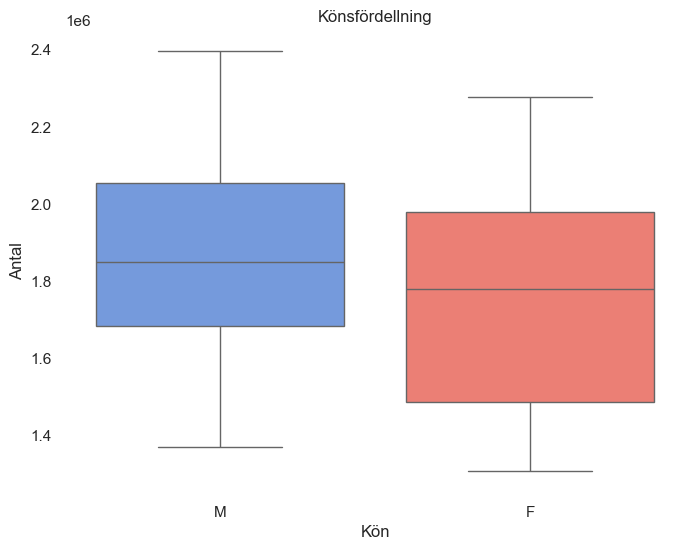

In [69]:


# Setting the style to 'white' which has no frames
sns.set(style="white")
# Plotting
plt.figure(figsize=(8, 6))
bar_plot = sns.boxplot(x='Gender', y='SalesLastYear', data=sales_gender[sales_gender['SalesLastYear'] > 0], palette=["#6495ED", "#FF6F61"])
plt.title('Könsfördellning')
plt.xlabel('Kön')
plt.ylabel('Antal')

# Removing the frame
for spine in bar_plot.spines.values():
    spine.set_visible(False)


plt.show()


In [71]:
import scipy.stats as stats
# Performing t-test

sales_men = sales_gender[sales_gender['SalesLastYear'] > 0][sales_gender['Gender']=='M']['SalesLastYear'].to_list()
sales_women = sales_gender[sales_gender['SalesLastYear'] > 0][sales_gender['Gender']=='F']['SalesLastYear'].to_list()

# Assuming sales_women and sales_men are already defined

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_ind(sales_women, sales_men, equal_var=False)

# Calculating the Confidence Interval
# Standard Error of the Difference in Means
sed = np.sqrt(np.var(sales_women, ddof=1)/len(sales_women) + np.var(sales_men, ddof=1)/len(sales_men))

# Critical value from t-distribution
degree_freedom = len(sales_women) + len(sales_men) - 2
confidence_level = 0.95
t_critical = np.abs(stats.t.ppf((1-confidence_level)/2, degree_freedom))

# Confidence interval
margin_error = t_critical * sed
mean_diff = np.mean(sales_women) - np.mean(sales_men)
confidence_interval = (mean_diff - margin_error, mean_diff + margin_error)

# Output the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)
print("95% Confidence Interval:", confidence_interval)

# Interpretation
alpha = 0.05  # significance level
if p_value < alpha:
    print("We reject the null hypothesis. There is a significant difference in sales between men and women.")
else:
    print("We fail to reject the null hypothesis. There is no significant difference in sales between men and women.")

    
# # Perform a two-sample t-test
# t_statistic, p_value = stats.ttest_ind(sales_women, sales_men, equal_var=False)

# # Output the results
# print("T-statistic:", t_statistic)
# print("P-value:", p_value)

# # Interpretation
# alpha = 0.05  # significance level
# if p_value < alpha:
#     print("We reject the null hypothesis. There is a significant difference in sales between men and women.")
# else:
#     print("We fail to reject the null hypothesis. There is no significant difference in sales between men and women.")

T-statistic: -0.5459954290469845
P-value: 0.5966977048710802
95% Confidence Interval: (-539215.6789327734, 324864.476647059)
We fail to reject the null hypothesis. There is no significant difference in sales between men and women.


/var/folders/l6/_mq5j9z968v8v8r5l_th36vr0000gn/T/ipykernel_60631/1197703052.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sales_men = sales_gender[sales_gender['SalesLastYear'] > 0][sales_gender['Gender']=='M']['SalesLastYear'].to_list()
/var/folders/l6/_mq5j9z968v8v8r5l_th36vr0000gn/T/ipykernel_60631/1197703052.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sales_women = sales_gender[sales_gender['SalesLastYear'] > 0][sales_gender['Gender']=='F']['SalesLastYear'].to_list()


# 3. Exploring Sales for products per location
1. Identifying the top 3 cellers, identifying top 3 locations by total sales.
2. Selecting the orders for the top cellers and constructing the table with names instead of ID for: - Location name, - Product name. 
3. Creating timeseries for sales progression for the top 3 locations for the most sold item. 

In [28]:
schema_overview_df[(schema_overview_df['Schema'] == 'Sales')]['Table'].unique()

array(['CountryRegionCurrency', 'CreditCard', 'Currency', 'CurrencyRate',
       'Customer', 'PersonCreditCard', 'SalesOrderDetail',
       'SalesOrderHeader', 'SalesOrderHeaderSalesReason', 'SalesPerson',
       'SalesPersonQuotaHistory', 'SalesReason', 'SalesTaxRate',
       'SalesTerritory', 'SalesTerritoryHistory', 'ShoppingCartItem',
       'SpecialOffer', 'SpecialOfferProduct', 'Store'], dtype=object)

In [30]:
schema_overview_df[(schema_overview_df['Schema'] == 'Sales') & (schema_overview_df['Table'] == 'SalesOrderDetail')]

,Schema,Table,Column,Type,Key
378,Sales,SalesOrderDetail,SalesOrderID,INTEGER,Primary Key
379,Sales,SalesOrderDetail,SalesOrderDetailID,INTEGER,Primary Key
380,Sales,SalesOrderDetail,CarrierTrackingNumber,"NVARCHAR(25) COLLATE ""SQL_Latin1_General_CP1_C...",None
381,Sales,SalesOrderDetail,OrderQty,SMALLINT,None
382,Sales,SalesOrderDetail,ProductID,INTEGER,Foreign Key
383,Sales,SalesOrderDetail,SpecialOfferID,INTEGER,Foreign Key
384,Sales,SalesOrderDetail,UnitPrice,MONEY,None
385,Sales,SalesOrderDetail,UnitPriceDiscount,MONEY,None
386,Sales,SalesOrderDetail,LineTotal,"NUMERIC(38, 6)",None
387,Sales,SalesOrderDetail,rowguid,UNIQUEIDENTIFIER,None


In [37]:
# 1. Identifying the top 3 cellers
sql = '''
SELECT
ProductID,
SUM(LineTotal) as Product_Total_Sales
FROM Sales.SalesOrderDetail
GROUP BY ProductID
ORDER BY Product_Total_Sales Desc
'''

Product_Total_Sales = pd.read_sql(sql = sql, con=connection)
Product_Total_Sales

,ProductID,Product_Total_Sales
0,782,4.400593e+06
1,783,4.009495e+06
2,779,3.693678e+06
3,780,3.438479e+06
4,781,3.434257e+06
...,...,...
261,914,1.480752e+03
262,943,1.198992e+03
263,897,8.002080e+02
264,710,5.130000e+02


### Checking the info abt relevant tables.

In [57]:
schema_overview_df[(schema_overview_df['Schema'] == 'Sales') & (schema_overview_df['Table'] == 'SalesOrderHeader')]

,Schema,Table,Column,Type,Key
389,Sales,SalesOrderHeader,SalesOrderID,INTEGER,Primary Key
390,Sales,SalesOrderHeader,RevisionNumber,TINYINT,None
391,Sales,SalesOrderHeader,OrderDate,DATETIME,None
392,Sales,SalesOrderHeader,DueDate,DATETIME,None
393,Sales,SalesOrderHeader,ShipDate,DATETIME,None
394,Sales,SalesOrderHeader,Status,TINYINT,None
395,Sales,SalesOrderHeader,OnlineOrderFlag,BIT,None
396,Sales,SalesOrderHeader,SalesOrderNumber,"NVARCHAR(25) COLLATE ""SQL_Latin1_General_CP1_C...",None
397,Sales,SalesOrderHeader,PurchaseOrderNumber,"NVARCHAR(25) COLLATE ""SQL_Latin1_General_CP1_C...",None
398,Sales,SalesOrderHeader,AccountNumber,"NVARCHAR(15) COLLATE ""SQL_Latin1_General_CP1_C...",None


In [58]:
schema_overview_df[(schema_overview_df['Schema'] == 'Sales') & (schema_overview_df['Table'] == 'SalesTerritory')]

,Schema,Table,Column,Type,Key
443,Sales,SalesTerritory,TerritoryID,INTEGER,Primary Key
444,Sales,SalesTerritory,Name,"NVARCHAR(50) COLLATE ""SQL_Latin1_General_CP1_C...",None
445,Sales,SalesTerritory,CountryRegionCode,"NVARCHAR(3) COLLATE ""SQL_Latin1_General_CP1_CI...",Foreign Key
446,Sales,SalesTerritory,Group,"NVARCHAR(50) COLLATE ""SQL_Latin1_General_CP1_C...",None
447,Sales,SalesTerritory,SalesYTD,MONEY,None
448,Sales,SalesTerritory,SalesLastYear,MONEY,None
449,Sales,SalesTerritory,CostYTD,MONEY,None
450,Sales,SalesTerritory,CostLastYear,MONEY,None
451,Sales,SalesTerritory,rowguid,UNIQUEIDENTIFIER,None
452,Sales,SalesTerritory,ModifiedDate,DATETIME,None


In [59]:
schema_overview_df[(schema_overview_df['Schema'] == 'Production') & (schema_overview_df['Table'] == 'Product')]

,Schema,Table,Column,Type,Key
165,Production,Product,ProductID,INTEGER,Primary Key
166,Production,Product,Name,"NVARCHAR(50) COLLATE ""SQL_Latin1_General_CP1_C...",None
167,Production,Product,ProductNumber,"NVARCHAR(25) COLLATE ""SQL_Latin1_General_CP1_C...",None
168,Production,Product,MakeFlag,BIT,None
169,Production,Product,FinishedGoodsFlag,BIT,None
170,Production,Product,Color,"NVARCHAR(15) COLLATE ""SQL_Latin1_General_CP1_C...",None
171,Production,Product,SafetyStockLevel,SMALLINT,None
172,Production,Product,ReorderPoint,SMALLINT,None
173,Production,Product,StandardCost,MONEY,None
174,Production,Product,ListPrice,MONEY,None


###  Constructing the table with top 5 celler including Location, Product name and Date

In [179]:
''' 

'''
cte_sql = """ 
WITH CTE_Products AS (
    SELECT
        SD.ProductID,
        SD.SalesOrderID,
        SD.LineTotal,
        SD.ModifiedDate,
        Sales.TerritoryID
    FROM Sales.SalesOrderDetail AS SD
    INNER JOIN Sales.SalesOrderHeader AS Sales 
        ON SD.SalesOrderID = Sales.SalesOrderID
    WHERE 
        SD.ProductID IN (782, 783, 779, 780, 781)

)
SELECT 
    CTE_Products.SalesOrderID,
    CTE_Products.LineTotal,
    CTE_Products.ModifiedDate,
    Territory.Name AS TerritoryName,
    Product.Name AS ProductName
FROM CTE_Products
INNER JOIN Sales.SalesTerritory AS Territory
    ON CTE_Products.TerritoryID = Territory.TerritoryID
INNER JOIN Production.Product AS Product
    ON CTE_Products.ProductID = Product.ProductID;

"""

top_products = pd.read_sql(sql = cte_sql, con=connection)
#top_products.to_csv('top_products.csv')

In [180]:
top_products.describe(include='all')

,SalesOrderID,LineTotal,ModifiedDate,TerritoryName,ProductName
count,5617.000000,5617.000000,5617,5617,5617
unique,NaN,NaN,NaN,10,5
top,NaN,NaN,NaN,Southwest,"Mountain-200 Black, 38"
freq,NaN,NaN,NaN,1171,1252
mean,56660.073349,3378.405090,2013-07-07 06:12:14.484600320,NaN,NaN
min,46604.000000,1229.458900,2012-05-30 00:00:00,NaN,NaN
25%,49193.000000,2294.990000,2013-01-02 00:00:00,NaN,NaN
50%,53531.000000,2319.990000,2013-07-31 00:00:00,NaN,NaN
75%,63985.000000,3728.555400,2014-01-10 00:00:00,NaN,NaN
max,74139.000000,20607.311175,2014-05-30 00:00:00,NaN,NaN


In [181]:
for column in top_products.columns:
    unique = top_products[f'{column}'].unique()
    if len(unique) < 20:
        print(f'column: {column} has the follwoing items {unique}')
        print('____________________')

column: TerritoryName has the follwoing items ['Southeast' 'Canada' 'Northeast' 'Northwest' 'Southwest' 'France'
 'Central' 'Australia' 'Germany' 'United Kingdom']
____________________
column: ProductName has the follwoing items ['Mountain-200 Black, 38' 'Mountain-200 Black, 42'
 'Mountain-200 Silver, 38' 'Mountain-200 Silver, 42'
 'Mountain-200 Silver, 46']
____________________


In [182]:
top_products.dtypes

SalesOrderID              int64
LineTotal               float64
ModifiedDate     datetime64[ns]
TerritoryName            object
ProductName              object
dtype: object

In [183]:
# Extract year, month, and day
top_products['Year'] = top_products['ModifiedDate'].dt.year
top_products['Month'] = top_products['ModifiedDate'].dt.month
top_products['Day'] = top_products['ModifiedDate'].dt.day
# Create a year-month label
top_products['YearMonth'] = top_products['ModifiedDate'].dt.strftime('%Y-%m')

In [184]:
top_products

,SalesOrderID,LineTotal,ModifiedDate,TerritoryName,ProductName,Year,Month,Day,YearMonth
0,46604,4917.8356,2012-05-30,Southeast,"Mountain-200 Black, 38",2012,5,30,2012-05
1,46604,3688.3767,2012-05-30,Southeast,"Mountain-200 Black, 42",2012,5,30,2012-05
2,46604,3728.5554,2012-05-30,Southeast,"Mountain-200 Silver, 38",2012,5,30,2012-05
3,46604,4971.4072,2012-05-30,Southeast,"Mountain-200 Silver, 42",2012,5,30,2012-05
4,46604,1242.8518,2012-05-30,Southeast,"Mountain-200 Silver, 46",2012,5,30,2012-05
...,...,...,...,...,...,...,...,...,...
5612,74130,2294.9900,2014-05-30,Canada,"Mountain-200 Black, 38",2014,5,30,2014-05
5613,74131,2319.9900,2014-05-30,Southwest,"Mountain-200 Silver, 38",2014,5,30,2014-05
5614,74132,2319.9900,2014-05-30,Canada,"Mountain-200 Silver, 46",2014,5,30,2014-05
5615,74136,2319.9900,2014-05-30,Australia,"Mountain-200 Silver, 38",2014,5,30,2014-05


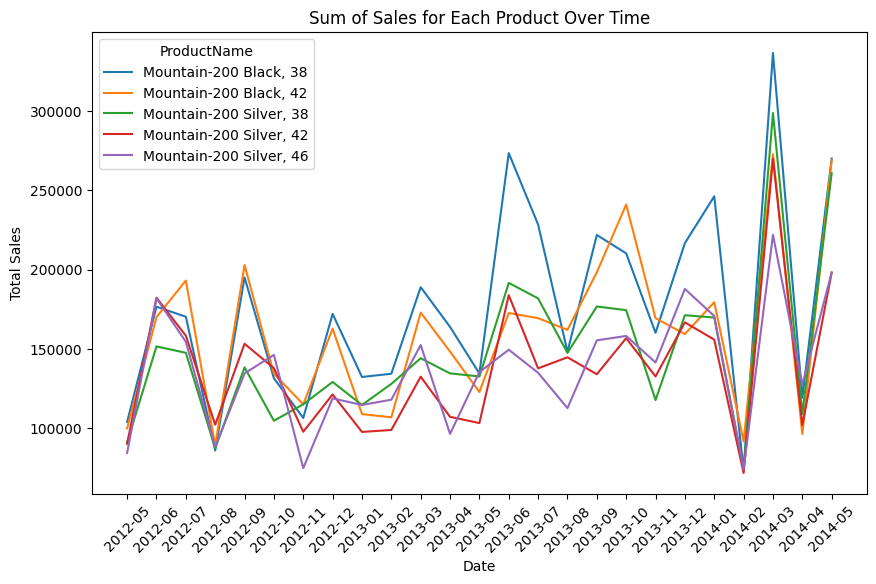

In [199]:
import seaborn as sns
import matplotlib.pyplot as plt
# Group by ProductName and ModifiedDate, then sum the LineTotal
grouped_df = top_products.groupby(['ProductName', 'YearMonth'])['LineTotal'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_df, x='YearMonth', y='LineTotal', hue='ProductName')
plt.title('Sum of Sales for Each Product Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

In [200]:
# Filter data for the two products
product1_sales = top_products[top_products['ProductName'] == 'Mountain-200 Black, 38']['LineTotal']
product2_sales = top_products[top_products['ProductName'] == 'Mountain-200 Silver, 38']['LineTotal']

# Perform t-test
t_stat, p_val = stats.ttest_ind(product1_sales, product2_sales, equal_var=True) # Use equal_var=False if variances are not similar

# Interpret results
print("T-Statistic:", t_stat)
print("P-Value:", p_val)

T-Statistic: 1.3056843605449138
P-Value: 0.19178804954916515


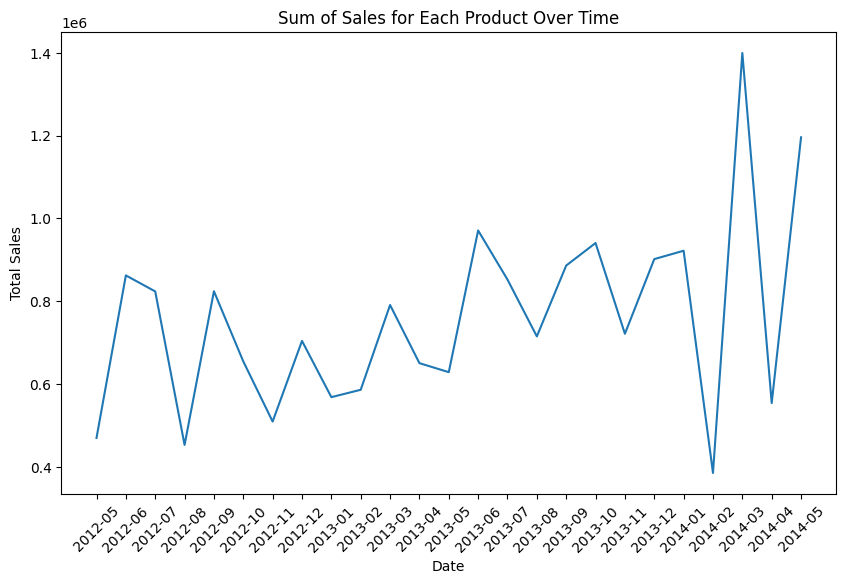

In [187]:

# Group by ProductName and ModifiedDate, then sum the LineTotal
grouped_df = top_products.groupby(['YearMonth'])['LineTotal'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_df, x='YearMonth', y='LineTotal', )
plt.title('Sum of Sales for Each Product Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

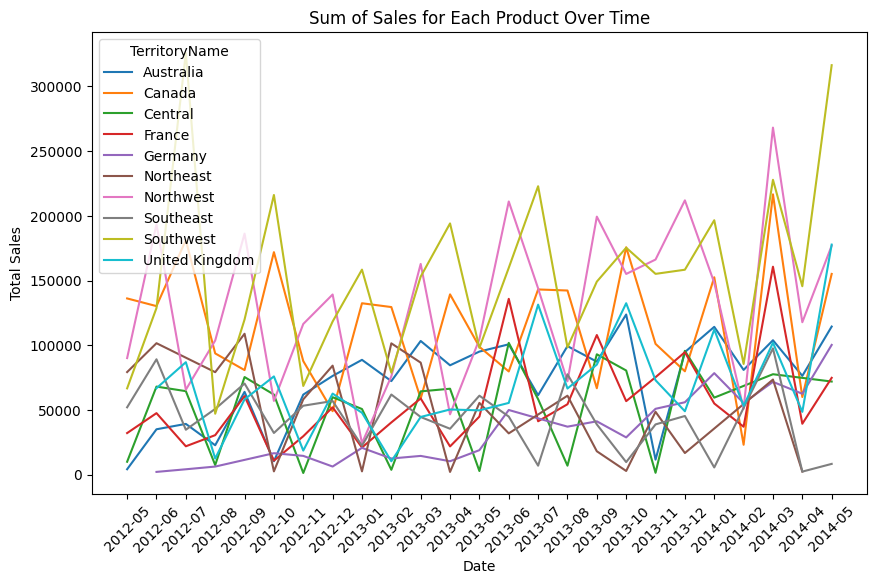

In [188]:
# Group by ProductName and ModifiedDate, then sum the LineTotal
grouped_df = top_products.groupby(['TerritoryName', 'YearMonth'])['LineTotal'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_df, x='YearMonth', y='LineTotal', hue='TerritoryName')
plt.title('Sum of Sales for Each Product Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

In [189]:

import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA
model = ols('LineTotal ~ C(TerritoryName)', data=top_products).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Output the ANOVA table
print(anova_table)

                        sum_sq      df          F         PR(>F)
C(TerritoryName)  2.866122e+09     9.0  57.226646  1.772187e-100
Residual          3.120214e+10  5607.0        NaN            NaN


In [190]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=top_products['LineTotal'], groups=top_products['TerritoryName'], alpha=0.05)
print(tukey.summary())

/Users/thor/anaconda3/envs/ec_utb/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
  group1      group2      meandiff  p-adj    lower      upper    reject
-----------------------------------------------------------------------
Australia         Canada  1658.8082    0.0  1278.9836  2038.6327   True
Australia        Central  2594.8141    0.0  2049.6631  3139.9652   True
Australia         France   808.6196    0.0   372.5246  1244.7145   True
Australia        Germany   185.2416 0.9723  -302.7811   673.2643  False
Australia      Northeast  2497.6646    0.0   1923.891  3071.4382   True
Australia      Northwest  1672.6686    0.0  1304.9007  2040.4365   True
Australia      Southeast  1585.2932    0.0   1061.434  2109.1523   True
Australia      Southwest  1049.4381    0.0    708.356  1390.5202   True
Australia United Kingdom   830.0672    0.0   415.8436  1244.2908   True
   Canada        Central    936.006    0.0   384.6544  1487.3575   True
   Canada         France  -850.1886    0.0 -1294.0103  -406.3669

In [191]:
# ANOVA
model = ols('LineTotal ~ C(ProductName)', data=top_products).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Output the ANOVA table
print(anova_table)

                      sum_sq      df         F    PR(>F)
C(ProductName)  4.486502e+07     4.0  1.850069  0.116351
Residual        3.402339e+10  5612.0       NaN       NaN


# Comparing trends of different item

In [136]:
# Calculate overall monthly average
overall_monthly_avg = top_products.groupby('YearMonth')['LineTotal'].sum()

# Calculate monthly average for each territory
territory_monthly_avg = top_products.groupby(['ProductName', 'YearMonth'])['LineTotal'].sum().reset_index()

In [137]:
territory_monthly_avg

,ProductName,YearMonth,LineTotal
0,"Mountain-200 Black, 38",2012-05,104094.186900
1,"Mountain-200 Black, 38",2012-06,176632.262200
2,"Mountain-200 Black, 38",2012-07,170311.205880
3,"Mountain-200 Black, 38",2012-08,86062.123200
4,"Mountain-200 Black, 38",2012-09,195074.145900
...,...,...,...
120,"Mountain-200 Silver, 46",2014-01,170751.264000
121,"Mountain-200 Silver, 46",2014-02,74239.680000
122,"Mountain-200 Silver, 46",2014-03,221912.611476
123,"Mountain-200 Silver, 46",2014-04,127599.450000


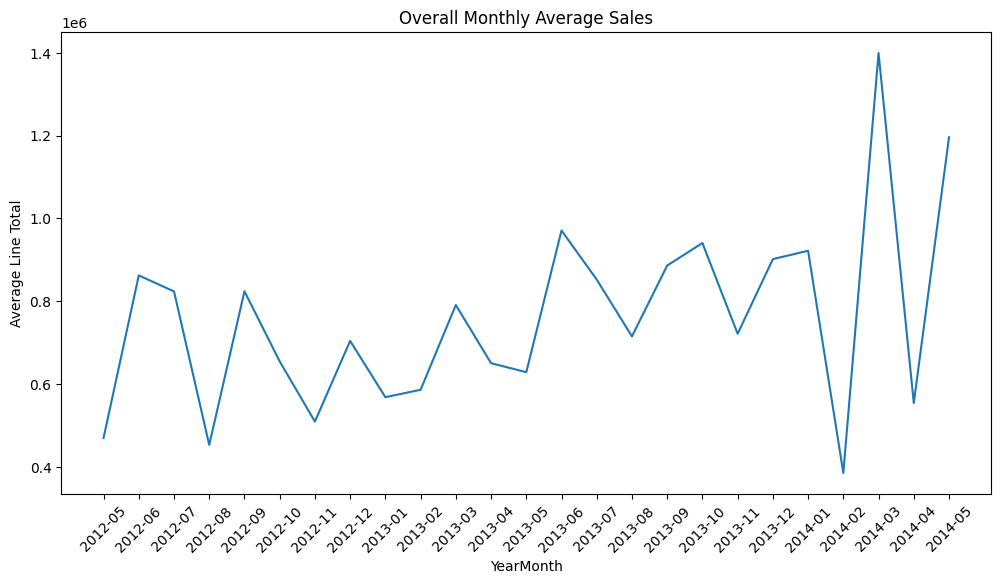

In [131]:
# Plotting the overall monthly average
plt.figure(figsize=(12, 6))
sns.lineplot(data=overall_monthly_avg)
plt.title('Overall Monthly Average Sales')
plt.xlabel('YearMonth')
plt.ylabel('Average Line Total')
plt.xticks(rotation=45)
plt.show()

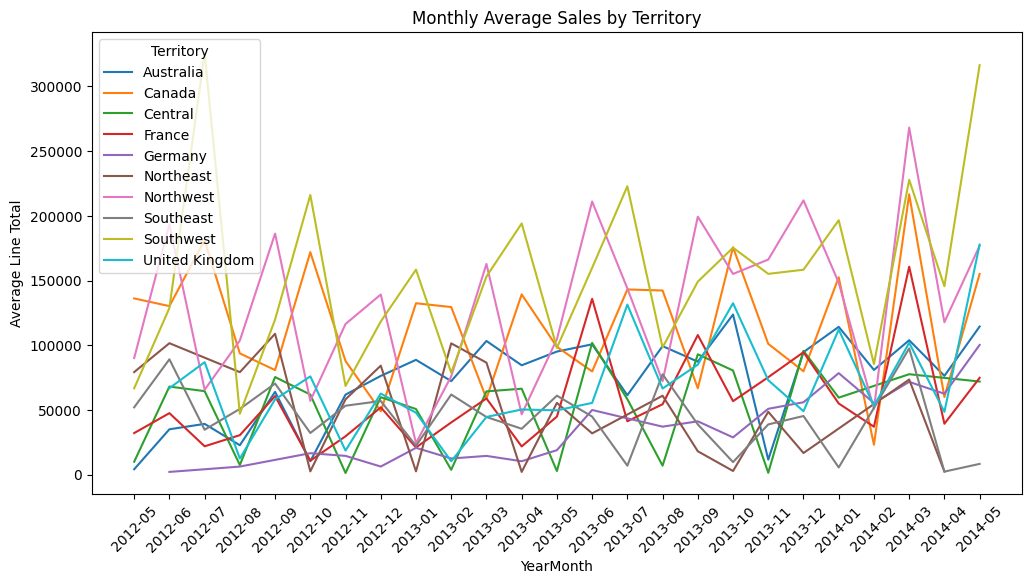

In [135]:
# Plotting the monthly average for each territory
plt.figure(figsize=(12, 6))
sns.lineplot(x='YearMonth', y='LineTotal', hue='TerritoryName', data=territory_monthly_avg)
plt.title('Monthly Average Sales by Territory')
plt.xlabel('YearMonth')
plt.ylabel('Average Line Total')
plt.xticks(rotation=45)
plt.legend(title='Territory')
plt.show()

In [127]:
overall_monthly_avg

YearMonth
2012-05    5343.313942
2012-06    4049.455359
2012-07    4268.909988
2012-08    3542.088446
2012-09    3763.817878
2012-10    3638.923712
2012-11    3127.290158
2012-12    3216.763838
2013-01    2747.188740
2013-02    3533.025772
2013-03    3215.902331
2013-04    2879.435983
2013-05    3399.977286
2013-06    4149.631291
2013-07    4241.144579
2013-08    3390.298114
2013-09    3588.510794
2013-10    3335.861433
2013-11    2797.234922
2013-12    3209.575234
2014-01    2945.972088
2014-02    2309.211557
2014-03    3771.986990
2014-04    2310.198333
2014-05    3155.368918
Name: LineTotal, dtype: float64

In [ ]:
# Perform t-tests
results = []
for (territory, month), group in territory_monthly_avg.groupby(['TerritoryName', 'YearMonth']):
    overall_avg = overall_monthly_avg.loc[month]
    t_stat, p_val = stats.ttest_1samp(
        top_products[(top_products['TerritoryName'] == territory) & (top_products['YearMonth'] == month)]['LineTotal'],
        overall_avg)
    results.append((territory, month, t_stat, p_val))